In [250]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

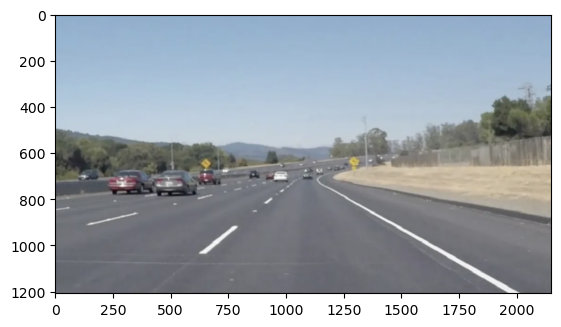

In [251]:
road = cv2.imread('images/road3.jpg')
road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
plt.imshow(road)

In [252]:
# function definition that creates triangle roi of current road
def region_of_interest(road, vertices):

  # creates black screen with same shape as input road image
  # no need to specify dimensions of road image like np.zeros
  mask = np.zeros_like(road)

  # get number of color channels in image
  # (255,) * channels creates a white color matching the image format
  # ie. (255,255,255) for RGB and (255,) for grayscale 
  if len(road.shape) == 3:
    match_mask_color = (255,) * road.shape[2]

  else:
    match_mask_color = 255
    
  # fill roi with white using to defined vertices
  cv2.fillPoly(mask, vertices, match_mask_color)

  # fills in the roi with the actual image of the road
  # only pixels inside the roi will be shown, everything else is black
  masked_image = cv2.bitwise_and(road, mask)
  return masked_image

Text(0.5, 1.0, 'Current Lane Detection')

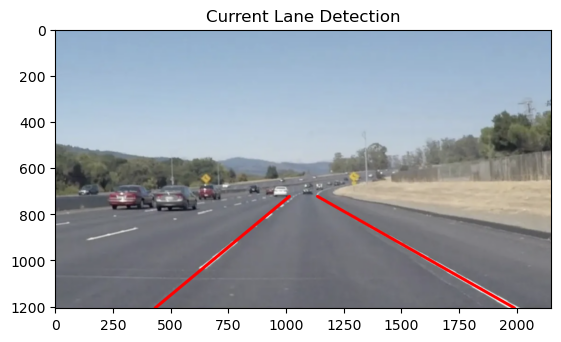

In [253]:
road_grey = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
road_gaussian = cv2.GaussianBlur(road_grey, (15,15), 0)
lower = 50
upper = 150
road_canny = cv2.Canny(road_gaussian, lower, upper)
kernel = np.ones((5,5), np.uint8)
road_dilation = cv2.dilate(road_canny, kernel, 1)

height, width, channels = road.shape
vertices = [
  (0, height),
  (width/2, height/2),
  (width, height)
]

road_roi = region_of_interest(road_dilation, np.array([vertices], np.int32))
road_copy = np.copy(road)

lines = cv2.HoughLinesP(road_roi, 1, np.pi/180, 40, minLineLength=60)
  
# initialize variables
left_x = []
right_x = []
left_y = []
right_y = []

for line in lines:
  x1, y1, x2, y2 = line[0]

  if (x2 - x1) == 0:
    break

  slope = (y2 - y1) / (x2 - x1)

  if abs(slope) < 0.5:
    continue

  if slope <= -0.1:
    left_x.extend([x1, x2])
    left_y.extend([y1, y2])

  else:
    right_x.extend([x1, x2])
    right_y.extend([y1, y2])

min_y = int(road.shape[0] * 3/5)
max_y = int(road.shape[0])

left_polynomial = np.poly1d(np.polyfit(left_y, left_x, deg=1))
right_polynomial = np.poly1d(np.polyfit(right_y, right_x, deg=1))

left_start = left_polynomial(max_y)
left_end = left_polynomial(min_y)

right_start = right_polynomial(max_y)
right_end = right_polynomial(min_y)

cv2.line(road_copy, (int(left_start), max_y), (int(left_end), min_y), (255,0,0), 11)
cv2.line(road_copy, (int(right_start), max_y), (int(right_end), min_y), (255,0,0), 11)

plt.imshow(road_copy)
plt.title('Current Lane Detection')

In [254]:
def line_formation(frame, roi_vertices, min_y, max_y):
  
  # initialize variables
  left_x = []
  right_x = []
  left_y = []
  right_y = []


  # grayscale
  frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  # gaussian blur
  frame_gaussian = cv2.GaussianBlur(frame_grey, (15,15), 0)  

  # canny edge
  lower = 10
  upper = 90
  frame_canny = cv2.Canny(frame_gaussian, lower, upper)

  # roi with dilation / erosion
  # THIS is most important step for getting best line detection when performing hough line transforms 
  kernel = np.ones((3,3), np.uint8)
  frame_dilation = cv2.dilate(frame_canny, kernel, 1)

  # after detecting all possible edges, get the edges only within ROI
  video_roi = region_of_interest(frame_dilation, np.array([roi_vertices], np.int32))

  # get subset of lines possible through probablistic hough transform
  lines = cv2.HoughLinesP(video_roi, 1, np.pi/180, 20, minLineLength=5)

  # loop through each line detected by probablistic hough transform
  for line in lines:
    # gives four coordinates
    x1, y1, x2, y2 = line[0]

    # checks for vertical lines
    if (x2 - x1) != 0:
      # find linear equation of all 
      # y2 - y1 / x2 - x1
      tempSlope = (y2 - y1) / (x2 - x1)

      # separate into left and right lanes based on slope
      if tempSlope < -0.1:
        # use .extend over .append 
        # makes sure not appending sublists, just adds as a 1D array
        left_x.extend([x1, x2])
        left_y.extend([y1, y2])

      elif tempSlope > 0.1:
        right_x.extend([x1, x2])
        right_y.extend([y1, y2])

  # get copy of original frame, so we can append detected lines on each frame
  # we don't want to display the same frames with lines later when video plays
  og_with_lines = np.copy(frame)

  # split the slopes into left and right lines
  # find where the lines should start and end
  # get a polynomial function that will draw out these lines using the slope?

  # get slope and intercept of left lane
  left_coefficients = np.polyfit(left_y, left_x, deg=1)
  # get y values according to input
  left_lane = np.poly1d(left_coefficients)


  # get slope and intercept of right lane
  right_coefficients = np.polyfit(right_y, right_x, deg=1)
  # get y values according to input
  right_lane = np.poly1d(right_coefficients)

  # one line for left side
  cv2.line(og_with_lines, 
          (int(left_lane(min_y)), max_y), 
          (int(left_lane(max_y)), min_y),
          (255, 0, 0), 5)
    
  # one line for right side
  cv2.line(og_with_lines,
          (int(right_lane(min_y)), max_y),
          (int(right_lane(max_y)), min_y),
          (255, 0, 0), 5)

  return og_with_lines

-15.751330504765047


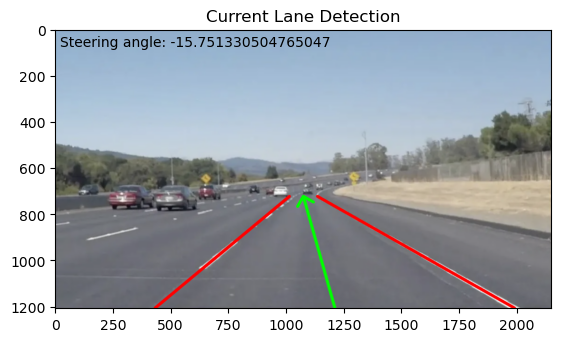

In [255]:
# basic noise reduction techniques
road_grey = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
road_gaussian = cv2.GaussianBlur(road_grey, (15,15), 0)
lower = 50
upper = 150
road_canny = cv2.Canny(road_gaussian, lower, upper)
kernel = np.ones((5,5), np.uint8)
road_dilation = cv2.dilate(road_canny, kernel, 1)

# used for ROI calculations
height, width, channels = road.shape
# triangle dimensions used for ROI
# only want the lane the car is in
vertices = [
  (0, height),
  (width/2, height/2),
  (width, height)
]

# get ROI so we can detect left/right lanes later on
road_roi = region_of_interest(road_dilation, np.array([vertices], np.int32))
road_copy = np.copy(road)

# draw lines on that ROI
lines = cv2.HoughLinesP(road_roi, 1, np.pi/180, 40, minLineLength=60)
  
# initialize variables
# will be used to separate left/right lanes
left_x = []
right_x = []
left_y = []
right_y = []

# loop through all lines detected in hough transform
for line in lines:
  x1, y1, x2, y2 = line[0]

  # make sure no undefined slope
  # is so, move onto next line
  if (x2 - x1) == 0:
    break

  # slope calculation to get line info
  slope = (y2 - y1) / (x2 - x1)

  # move onto next line if slope is less than 0.5
  if abs(slope) < 0.5:
    continue

  # since origin is top left...
  # negative slopes indicate bottom left moving toward top right
  # representing line of the left lane
  if slope <= -0.1:
    left_x.extend([x1, x2])
    left_y.extend([y1, y2])

  # positive slopes indicate bottom right moving toward top left
  # representing line of the right lane
  else:
    right_x.extend([x1, x2])
    right_y.extend([y1, y2])

# want to see where car is heading
# also want to see lanes ahear
min_y = int(road.shape[0] * 3/5)
# want to see where car is positioned
max_y = int(road.shape[0])

# polyfit gives coefficients for function
# poly1d turns those coefficients into a function
left_polynomial = np.poly1d(np.polyfit(left_y, left_x, deg=1))
# able to get points on a line from derived function above
left_start = left_polynomial(max_y)
left_end = left_polynomial(min_y)

# polyfit gives coefficients for function
# poly1d turns those coefficients into a function
right_polynomial = np.poly1d(np.polyfit(right_y, right_x, deg=1))
# able to get points on a line from derived function above
right_start = right_polynomial(max_y)
right_end = right_polynomial(min_y)

# get middle position between the detected left/right lanes
middle_start = (left_start + right_start) / 2
middle_end = (left_end + right_end) / 2

# find center of image
# will be used to calculate steering angle
# where car is pointing from
image_center = width / 2
# x component
# lateral offset --> how far off the car is from the center
lateral_displacement = middle_end - middle_start
# y component
# how far away car is from road ahead
# distance to target space
direction_ahead = max_y - min_y

cv2.line(road_copy, (int(left_start), max_y), (int(left_end), min_y), (255,0,0), 11)
cv2.line(road_copy, (int(right_start), max_y), (int(right_end), min_y), (255,0,0), 11)
#cv2.line(road_copy, (int(middle_start), max_y), (int(middle_end), min_y), (0, 0, 255), 11)
# path that car should drive
cv2.arrowedLine(road_copy, (int(middle_start), max_y), (int(middle_end), min_y), (0, 255, 0), 11)

# how much i need to steer to stay in the center of the lane when looking afar
steering_angle = math.atan2(lateral_displacement, direction_ahead)
steering_angle = math.degrees(steering_angle)

# display image
plt.imshow(road_copy)
plt.text(20, 70, f'Steering angle: {steering_angle}')
plt.title('Current Lane Detection')
print(steering_angle)

In [176]:
# # read video as object
# video = cv2.VideoCapture('road_video.mp4')

# # read only first frame of video
# read, first_frame = video.read()

# # get info from first frame, which will apply to ROI and displaying lines later
# height, width, channels = first_frame.shape

# # get dimensions for ROI based on first frame
# # ROI will be same on all frames later on
# roi_vertices = [
#   (0, height),
#   (width / 2, height / 2),
#   (width, height),
# ]

# # get where the line should start and end on each frame
# # will be the same for all frames
# min_y = int(height * 1/2)
# max_y = int(height)

# # release video to restard from beginning
# video.release()

# # read video as object again, want to start from beginning again
# video = cv2.VideoCapture('road_video.mp4')

# # keep playing video until it can't anymore or we break out
# while True:
#   read, frame = video.read()

#   if not read:
#     break

#   # function call to get current lane detection
#   processed_frames = line_formation(frame, roi_vertices, min_y, max_y)

#   # then plot the line for each line
#   cv2.imshow('Current Lane Detection', processed_frames)

#   if cv2.waitKey(20) & 0xFF == ord('q'):
#     break

# video.release()
# cv2.destroyAllWindows()

In [177]:
# # parameters (image, rho, theta, threshold)
# # rho = how far away from center origin
# # theta = how tilted is that line
# # only edges exceeding 200 threshold will be recognized as lines
# # use probabilistic HT --> more efficient, only using subset of edges
# # less computational
# # edges too thin from canny edge --> change threshold to recognize lines easier
# # minLineLength --> used to filter out smaller "noise" lines



# # better to work with dilation than canny edge
# # edges are easier to pick up by hough line transform --> better line detection


# # loop through each line detected by probablistic hough transform
# for line in lines:
#   # gives four coordinates
#   x1, y1, x2, y2 = line[0]

#   # draws the detected lines in red onto original image
#   cv2.line(road_with_lines, (x1, y1), (x2, y2), (255,0,0), 3)


#   # checks for vertical lines
#   if (x2 - x1) != 0:
#     # find linear equation of all 
#     # y2 - y1 / x2 - x1
#     tempSlope = (y2 - y1) / (x2 - x1)

#     # separate into left and right lanes based on slope
#     if tempSlope < -0.1:
#       # use .extend over .append 
#       # makes sure not appending sublists, just adds as a 1D array
#       left_x.extend([x1, x2])
#       left_y.extend([y1, y2])

#     elif tempSlope > 0.1:
#       right_x.extend([x1, x2])
#       right_y.extend([y1, y2])


#   # split the slopes into left and right lines
#   # find where the lines should start and end
#   # get a polynomial function that will draw out these lines using the slope?

#   # get slope and intercept of left lane
#   left_coefficients = np.polyfit(left_x, left_y, deg=1)
#   # get y values according to input
#   left_lane = np.poly1d(left_coefficients)


#   # get slope and intercept of right lane
#   right_coefficients = np.polyfit(right_x, right_y, deg=1)
#   # get y values according to input
#   right_lane = np.poly1d(right_coefficients)

#   cv2.line(road_with_lines, 
#            (left_lane(min_y), left_lane(max_y)), 
#            (right_lane(), right_lane())
#            (255, 0, 0), 5)






#   # then plot the line for each line



# plt.imshow(road_with_lines)
# plt.title('Straight Road Line Detection')



In [256]:
# get video object
video = cv2.VideoCapture('videos/road_video.mp4')

# only read first frame
read, first_frame = video.read()

# used for ROI calculations
height, width, channels = first_frame.shape
# triangle dimensions used for ROI
# only want the lane the car is in
vertices = [
  (0, height),
  (width/2, height/2),
  (width, height)
]

# release helps us so we can restart video and apply ROI on all frames, including first frame
video.release()

# get video object again
video = cv2.VideoCapture('videos/road_video.mp4')

while True:
  # read all frames in video
  read, frames = video.read()
  
  # exits loop if frame cannot be read
  if not read:
    break

  # basic noise reduction techniques
  road_grey = cv2.cvtColor(frames, cv2.COLOR_BGR2GRAY)
  # too much blur causes difficulty detecting the dashed lanes
  # originally (15,15) --> now (5,5)
  # continuous detection now
  road_gaussian = cv2.GaussianBlur(road_grey, (5,5), 0)
  # changing the lower and upper limits causes 
  lower = 10
  upper = 90
  road_canny = cv2.Canny(road_gaussian, lower, upper)
  kernel = np.ones((5,5), np.uint8)
  road_dilation = cv2.dilate(road_canny, kernel, 1)

  # get ROI so we can detect left/right lanes later on
  road_roi = region_of_interest(road_dilation, np.array([vertices], np.int32))
  # will let us apply the detected lines on frames without manipulating original video
  road_copy = np.copy(frames)

  # threshold should be somewhat high to ensure no noisy lines are detected
  # make sure minLineLength is able to detect the dashed lines
  # maxLineGap ensures the dashed lanes are detected
  # maxLaneGap allows gaps between lines to become conjoined
  lines = cv2.HoughLinesP(road_roi, 1, np.pi/180, 70, minLineLength=30, maxLineGap=100)
    
  # initialize variables
  left_x = []
  right_x = []
  left_y = []
  right_y = []

  # loop through all lines detected in hough transform
  for line in lines:
    # will be used to separate left/right lanes
    x1, y1, x2, y2 = line[0]

    # make sure no undefined slope
    # is so, move onto next line
    if (x2 - x1) == 0:
      break

    # slope calculation to get line info
    slope = (y2 - y1) / (x2 - x1)

    # move onto next line if slope is less than 0.5
    if abs(slope) < 0.5:
      continue

    # since origin is top left...
    # negative slopes indicate bottom left moving toward top right
    # representing line of the left lane
    if slope <= -0.1:
      left_x.extend([x1, x2])
      left_y.extend([y1, y2])

    # positive slopes indicate bottom right moving toward top left
    # representing line of the right lane
    else:
      right_x.extend([x1, x2])
      right_y.extend([y1, y2])

  # want to see where car is heading
  # also want to see lanes ahear
  min_y = int(frames.shape[0] * 3/5)
  # want to see where car is positioned
  max_y = int(frames.shape[0])

# check if there are enough points for us to draw lines
  if (len(left_x) and len(left_y) >= 2):
    # polyfit gives coefficients for function
    # poly1d turns those coefficients into a function
    left_polynomial = np.poly1d(np.polyfit(left_y, left_x, deg=1))
    # able to get points on a line from derived function above
    left_start = left_polynomial(max_y)
    left_end = left_polynomial(min_y)
    # draw line from info above
    cv2.line(road_copy, (int(left_start), max_y), (int(left_end), min_y), (255,0,0), 5)

  # check if there are enough points for us to draw lines
  if (len(right_x) >= 2 and len(right_y) >= 2):
    # polyfit gives coefficients for function
    # poly1d turns those coefficients into a function
    right_polynomial = np.poly1d(np.polyfit(right_y, right_x, deg=1))
    # able to get points on a line from derived function above
    right_start = right_polynomial(max_y)
    right_end = right_polynomial(min_y)
    # draw line from info above
    cv2.line(road_copy, (int(right_start), max_y), (int(right_end), min_y), (255,0,0), 5)

  # show video with detected lanes
  cv2.imshow('Current Lane Detection', road_copy)

  if cv2.waitKey(20) & 0xFF == ord('q'):
    break

video.release()
cv2.destroyAllWindows()

In [257]:
# get video object
video = cv2.VideoCapture('videos/road_video.mp4')

# only read first frame
read, first_frame = video.read()

# used for ROI calculations
height, width, channels = first_frame.shape
# triangle dimensions used for ROI
# only want the lane the car is in
vertices = [
  (0, height),
  (width/2, height/2),
  (width, height)
]

# want to see where car is heading
# also want to see lanes ahear
min_y = int(first_frame.shape[0] * 3/5)
# want to see where car is positioned
max_y = int(first_frame.shape[0])

# release helps us so we can restart video and apply ROI on all frames, including first frame
video.release()

# get video object again
video = cv2.VideoCapture('videos/road_video.mp4')

while True:
  # read all frames in video
  read, frames = video.read()
  
  # exits loop if frame cannot be read
  if not read:
    break

  # basic noise reduction techniques
  road_grey = cv2.cvtColor(frames, cv2.COLOR_BGR2GRAY)
  # too much blur causes difficulty detecting the dashed lanes
  # originally (15,15) --> now (5,5)
  # continuous detection now
  road_gaussian = cv2.GaussianBlur(road_grey, (9,9), 0)
  # changing the lower and upper limits causes 
  lower = 10
  upper = 90
  road_canny = cv2.Canny(road_gaussian, lower, upper)
  kernel = np.ones((5,5), np.uint8)
  road_dilation = cv2.dilate(road_canny, kernel, 1)

  # get ROI so we can detect left/right lanes later on
  road_roi = region_of_interest(road_dilation, np.array([vertices], np.int32))
  # will let us apply the detected lines on frames without manipulating original video
  road_copy = np.copy(frames)

  # threshold should be somewhat high to ensure no noisy lines are detected
  # make sure minLineLength is able to detect the dashed lines
  # maxLineGap ensures the dashed lanes are detected
  # maxLaneGap allows gaps between lines to become conjoined
  lines = cv2.HoughLinesP(road_roi, 1, np.pi/180, 50, minLineLength=30, maxLineGap=100)
    
  # initialize variables
  left_x = []
  right_x = []
  left_y = []
  right_y = []

  # loop through all lines detected in hough transform
  for line in lines:
    # will be used to separate left/right lanes
    x1, y1, x2, y2 = line[0]

    # make sure no undefined slope
    # is so, move onto next line
    if (x2 - x1) == 0:
      continue

    # slope calculation to get line info
    slope = (y2 - y1) / (x2 - x1)

    # move onto next line if slope is less than 0.5
    if abs(slope) < 0.5:
      continue

    # since origin is top left...
    # negative slopes indicate bottom left moving toward top right
    # representing line of the left lane
    if slope <= -0.1:
      left_x.extend([x1, x2])
      left_y.extend([y1, y2])

    # positive slopes indicate bottom right moving toward top left
    # representing line of the right lane
    else:
      right_x.extend([x1, x2])
      right_y.extend([y1, y2])

# check if there are enough points for us to draw lines
  if (len(left_x) >= 2 and len(left_y) >= 2):
    # polyfit gives coefficients for function
    # poly1d turns those coefficients into a function
    left_polynomial = np.poly1d(np.polyfit(left_y, left_x, deg=1))
    # able to get points on a line from derived function above
    left_start = left_polynomial(max_y)
    left_end = left_polynomial(min_y)
    # draw line from info above
    cv2.line(road_copy, (int(left_start), max_y), (int(left_end), min_y), (255,0,0), 5)

  # check if there are enough points for us to draw lines
  if (len(right_x) >= 2 and len(right_y) >= 2):
    # polyfit gives coefficients for function
    # poly1d turns those coefficients into a function
    right_polynomial = np.poly1d(np.polyfit(right_y, right_x, deg=1))
    # able to get points on a line from derived function above
    right_start = right_polynomial(max_y)
    right_end = right_polynomial(min_y)
    # draw line from info above
    cv2.line(road_copy, (int(right_start), max_y), (int(right_end), min_y), (255,0,0), 5)

  # find midpoint of detected left/right lane
  middle_start = (left_start + right_start) / 2
  middle_end = (left_end + right_end) / 2

  # find center of image
  # will be used to calculate steering angle
  # where car is pointing from
  image_center = width / 2
  # x component
  # lateral offset --> how far off the car is from the center
  lateral_displacement = middle_end - middle_start
  # y component
  # how far away car is from road ahead
  # distance to target space
  direction_ahead = max_y - min_y

  # abs --> want steering angle to be positive, imaging pixels start in top left corner (opposite)
  steering_angle = math.degrees(math.atan2(lateral_displacement, direction_ahead))

  # draw arrow of where car should be heading
  cv2.arrowedLine(road_copy, (int(middle_start), max_y), (int(middle_end), min_y), (0,0, 225), 5)
  # show video with detected lanes
  cv2.putText(road_copy, f"Steering angle: {steering_angle}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
  cv2.imshow('Current Lane Detection', road_copy)

  if cv2.waitKey(20) & 0xFF == ord('q'):
    break

video.release()
cv2.destroyAllWindows()